### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

### Adjust settings

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
random.seed(10)

#### Problem statement <br><br> Customers visit different websites -> Customers sign up for a course and are called leads -> Leads contacted by marketing team -> Some leads get converted to paying customers. <br><br> Aim is to identify if a lead will be converted to a paying customer.

### Function: Verify class imbalance

In [3]:
def class_imbalance(df):
    
    print("Number of samples per class :\n")
    print(df["Converted"].value_counts())

    plt.title("Number of samples per class")
    df["Converted"].value_counts().plot.bar(color = "orange")
    plt.xlabel("Class")
    plt.ylabel("Number of samples")
    plt.show()

    class_0 = df["Converted"].value_counts()[0]
    class_1 = df["Converted"].value_counts()[1]
    sum = class_0 + class_1
    print("Class ratio (class_0/class_1):\n", round(class_0/class_1, 3))

### Function: Drop unwanted columns

In [4]:
def drop_cols(df, col_list):
    
    df.drop(col_list, axis=1, inplace = True)

### Function: Handle missing values

In [5]:
def handle_missing_values(df, col, key_word):
    
    if key_word == "mode":
        mode_value = df[col].mode()[0]
        df[col].fillna(value = mode_value, inplace = True)
    
    elif key_word == "median":
        median_value = df[col].median()
        df[col].fillna(value = median_value, inplace = True)
    
    elif key_word == "mean":
        mean_value = df[col].mean()
        df[col].fillna(value = mean_value, inplace = True)
    
    else:
        val = key_word        
        df[col].fillna(value = val, inplace = True)

### Function: Visualise impact of feature

In [6]:
def visualise_feature_impact(df, feature, f_type):
    
    if f_type == "categorical":
        
        val = df.groupby('Converted')[feature].value_counts()
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
        col = ["crimson", "green"]
        
        for i in range(0,2):
            val[i].plot(kind='bar',ax=axes[i],  color=col[i])
            
            axes[i].set_title(feature + " - distribution for class "+ str(i), fontsize=12)
            axes[i].set_ylabel("Count / Percentage", fontsize=12)
            axes[i].set_xlabel(feature, fontsize=12)
    
            totals = []
            for k in axes[i].patches:
                totals.append(k.get_height())

            total = sum(totals)
            for j in axes[i].patches:
                axes[i].text(j.get_x(), j.get_height(), \
                             str((j.get_height())) + "  (" + str(round((j.get_height()/total)*100, 2))+'%)', \
                             fontsize=11, color='black')
        
    elif f_type == "numerical":
        
        temp_df = pd.DataFrame(df[[feature,"Converted"]].copy())
        temp_df = remove_outliers(temp_df, feature)
        print("\n")
        print("Original number of samples :", df[feature].shape)
        print("Number of samples after outliers are removed :", temp_df[feature].shape)
        
        plt.figure(figsize = (12,5))
        sns.histplot(data=temp_df, x=feature, kde=True, hue = "Converted")
        plt.title(feature + " - distribution at class lavel")
        plt.show()

### Function: Remove outliers

In [7]:
def remove_outliers(df, col):
    
    perc_25 = np.percentile(df[col], 25)
    perc_75 = np.percentile(df[col], 75)
    iqr = perc_75 - perc_25
    ll = perc_25 - 1.5*iqr
    ul = perc_75 + 1.5*iqr
    
    print("\n IQR {} \n Lower limit {}\n Upper limit {}".format(iqr, ll, ul))
    print("\n Minimum {} \n Maximum {} \n".format(min(df[col]), max(df[col])))
    
    if min(df[col]) < ll and max(df[col]) > ul:
        print("There are samples which violate both upper limit and lower limit")
        idx1 = np.where(df[col] < ll)
        idx2 = np.where(df[col] > ul)
        idx = np.concatenate((idx1[0], idx2[0]), axis = None)
        #print(idx)
        print("Number of outliers ", len(idx))
        df.drop(idx, axis = 0, inplace = True)
        print("Outliers have been removed")

    elif min(df[col]) < ll and max(df[col]) <= ul:
        print("There are samples which violate only lower limit")
        idx = np.where(df[col] < ll)
        #print(idx[0])
        print("Number of outliers ", len(idx[0]))
        df.drop(idx[0], axis = 0, inplace = True)
        print("Outliers have been removed")
    
    elif min(df[col]) >= ll and max(df[col]) > ul:
        print("There are samples which violate only upper limit")
        idx = np.where(df[col] > ul)
        #print(idx[0])
        print("Number of outliers ", len(idx[0]))
        df.drop(idx[0], axis = 0, inplace = True)
        print("Outliers have been removed")
        
    else:
        print("No outliers in this data")
        
    df = df.reset_index()
    df.drop(columns=["index"], axis=1, inplace = True)
    
    return df

### Function: Encode categorical variable

In [8]:
def categorical_encode(df, col, key_word):
    
    if key_word == 'l_encode':
        le = preprocessing.LabelEncoder() 
        l_encodes = pd.DataFrame(le.fit_transform(df[col]).astype(str))
        l_encodes.columns = [col + "_encoded"]
        df = pd.concat([df, l_encodes], axis = 1)
        df.drop([col], axis = 1, inplace = True)
    
    elif key_word == 'o_encode':
        o_encodes = pd.get_dummies(df[col], drop_first= True).astype(int)
        df = pd.concat([df, o_encodes], axis = 1)
        df.drop([col], axis = 1, inplace = True)
    
    else:
        print("Please specify correct key-word")
        
    return df 

### Define path and load data

In [9]:
path = "/Users/sohinimitra/Documents/Kaggle/datasets/kaggle-lead-scoring-datasets/"

In [10]:
data = pd.read_csv(path + "Leads.csv")
data.sample(3)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
8693,612cb3c6-4878-48d6-8618-29338dd9cffa,583505,Landing Page Submission,Direct Traffic,No,No,0,2.0,346,2.0,Email Opened,United States,Human Resource Management,NaN,NaN,NaN,No,No,No,No,No,No,No,No,NaN,NaN,No,No,NaN,Mumbai,02.Medium,01.High,13.0,18.0,No,Yes,Modified
8901,1e77a06b-2b14-4845-8bb3-ca01464c1780,582097,Landing Page Submission,Direct Traffic,No,No,0,2.0,1736,2.0,Email Link Clicked,India,Marketing Management,Select,Working Professional,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Modified
6254,fb4189e8-f48f-445a-badd-f7b138cdd560,601816,API,Google,No,No,0,2.0,31,2.0,Olark Chat Conversation,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Not Sure,No,No,Select,Select,NaN,NaN,NaN,NaN,No,No,Modified


### Data description

In [11]:
data_descripton = pd.read_excel(path + "Leads Data Dictionary.xlsx")
data_descripton

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,NaN,NaN,NaN
1,NaN,Variables,Description
2,NaN,Prospect ID,A unique ID with which the customer is identified.
3,NaN,Lead Number,A lead number assigned to each lead procured.
4,NaN,Lead Origin,"The origin identifier with which the customer was identified to be a lead. Includes API, Landing Page Submission, etc."
5,NaN,Lead Source,"The source of the lead. Includes Google, Organic Search, Olark Chat, etc."
6,NaN,Do Not Email,An indicator variable selected by the customer wherein they select whether of not they want to be emailed about the course or not.
7,NaN,Do Not Call,An indicator variable selected by the customer wherein they select whether of not they want to be called about the course or not.
8,NaN,Converted,The target variable. Indicates whether a lead has been successfully converted or not.
9,NaN,TotalVisits,The total number of visits made by the customer on the website.


#### Note: From the data description it can be observed that the target variable is the column "Converted". Different features have been captured to understand the behavior of a lead getting converted to a paying customer. 

### Data overview

In [12]:
print("Shape of dataset :", data.shape)
print("\n")
print(data.info())

Shape of dataset : (9240, 37)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization        

#### Note: There are 9240 samples in this dataset. Most of the features are categorical in nature. There are several NULL values across different features in the dataset. 

### Check for class imbalance

Number of samples per class :

0    5679
1    3561
Name: Converted, dtype: int64


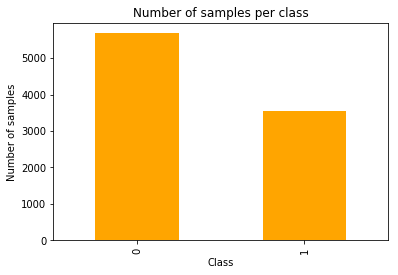

Class ratio (class_0/class_1):
 1.595


In [13]:
class_imbalance(data)

#### Note: Overall there is sufficent number of samples in both classes to learn from. The class ratio is less than 2. Class imbalance does not exist in the overall data.

### Identify irrelevant features

In [14]:
data.nunique()

Prospect ID                                      9240
Lead Number                                      9240
Lead Origin                                      5   
Lead Source                                      21  
Do Not Email                                     2   
Do Not Call                                      2   
Converted                                        2   
TotalVisits                                      41  
Total Time Spent on Website                      1731
Page Views Per Visit                             114 
Last Activity                                    17  
Country                                          38  
Specialization                                   19  
How did you hear about X Education               10  
What is your current occupation                  6   
What matters most to you in choosing a course    3   
Search                                           2   
Magazine                                         1   
Newspaper Article           

#### Note: <br> 1. Prospect ID and Lead Number are identifiers for each customer, hence can be avoided for training. <br> 2.  Activity/Profile Index/Score are redundant information, either Index or Score can be avoided for training. (Drop Score since Index privides infromation at a group level as Low-Medium-High) <br> 3. Last Activity and Last Notable Activity features are redundant, one of them can be avoided for training. (Drop Notable Activity)

In [15]:
col_list = ["Prospect ID","Lead Number","Asymmetrique Activity Score","Asymmetrique Profile Score","Last Activity"]
drop_cols(data, col_list)
print("Shape of dataset :",data.shape)
data.sample(3)

Shape of dataset : (9240, 32)


,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
7076,Landing Page Submission,Direct Traffic,No,No,1,2.0,84,2.0,Saudi Arabia,Supply Chain Management,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,High in Relevance,No,No,Select,Other Metro Cities,02.Medium,02.Medium,No,Yes,SMS Sent
39,Landing Page Submission,Google,No,No,1,4.0,25,4.0,India,Operations Management,Email,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,High in Relevance,No,No,Potential Lead,Other Cities of Maharashtra,02.Medium,01.High,No,No,Email Opened
4484,Landing Page Submission,Google,No,No,0,5.0,218,5.0,India,Finance Management,Online Search,NaN,NaN,No,No,No,No,No,No,No,No,NaN,NaN,No,No,NaN,Thane & Outskirts,NaN,NaN,No,No,SMS Sent


### Identify number of NaNs for each feature

In [16]:
data.isna().sum()

Lead Origin                                      0   
Lead Source                                      36  
Do Not Email                                     0   
Do Not Call                                      0   
Converted                                        0   
TotalVisits                                      137 
Total Time Spent on Website                      0   
Page Views Per Visit                             137 
Country                                          2461
Specialization                                   1438
How did you hear about X Education               2207
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                           0   
Magazine                                         0   
Newspaper Article                                0   
X Education Forums                               0   
Newspaper                                        0   
Digital Advertisement       

#### Note: <br> 1. Lead Quality has high number of NULL values. This feature will be dropped. <br> 2. Activity and Profile indexes will be retained despite high number of NULLs since they indicate behavior of a customer. <br> 3. Number of NULLs for Lead Source, TotalVisits and Page Views Per Visit is low, NULLs will be handled by using "Mode"/"Median"/"Mean".

In [17]:
col_list = ["Lead Quality"]
drop_cols(data, col_list)

In [18]:
handle_missing_values(data, "Lead Source", "mode")
handle_missing_values(data, "TotalVisits", "mean")
handle_missing_values(data, "Page Views Per Visit", "mean")
data.sample(3)

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
1122,Landing Page Submission,Google,No,No,0,3.0,68,3.0,India,"Banking, Investment And Insurance",Social Media,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in full time MBA,No,No,Select,Mumbai,02.Medium,01.High,No,No,Modified
5915,Landing Page Submission,Organic Search,No,No,1,15.0,1603,15.0,India,Media and Advertising,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,No,No,Potential Lead,Other Metro Cities,NaN,NaN,No,Yes,SMS Sent
3867,API,Olark Chat,No,No,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,NaN,No,No,NaN,NaN,NaN,NaN,No,No,Modified


###  Identify impact of features on target variable

Landing Page Submission    4886
API                        3580
Lead Add Form              718 
Lead Import                55  
Quick Add Form             1   
Name: Lead Origin, dtype: int64

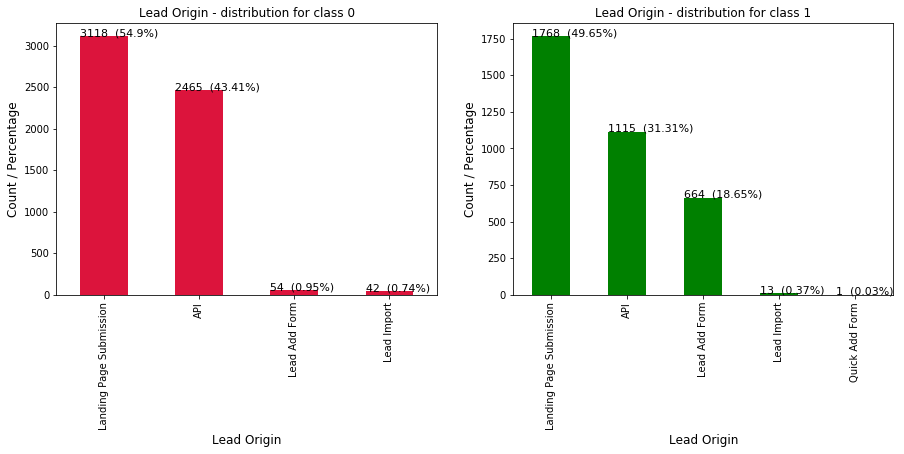

In [19]:
visualise_feature_impact(data, "Lead Origin", "categorical")
data["Lead Origin"].value_counts()

#### Note: <br> 1. If a lead arrives via "Lead Add Form", possibility of coversion is higher. This feature impacts the target variable. <br> 2. There is only one sample for "Quick Add Form". This sample may be ignored. 

Google               2904
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference            534 
Welingak Website     142 
Referral Sites       125 
Facebook             55  
bing                 6   
google               5   
Click2call           4   
Social Media         2   
Press_Release        2   
Live Chat            2   
NC_EDM               1   
Pay per Click Ads    1   
welearnblog_Home     1   
WeLearn              1   
testone              1   
youtubechannel       1   
blog                 1   
Name: Lead Source, dtype: int64

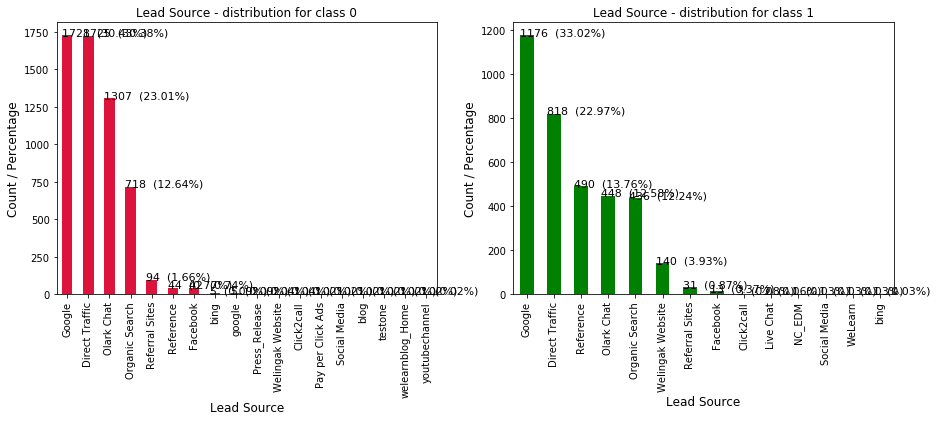

In [20]:
visualise_feature_impact(data, "Lead Source", "categorical")
data["Lead Source"].value_counts()

#### Note: <br> 1. "Google"-"google" represent the same source, this can be combined. <br> 2. Several sources have very few sample, such samples can be combined into a single category. 

No     8506
Yes    734 
Name: Do Not Email, dtype: int64

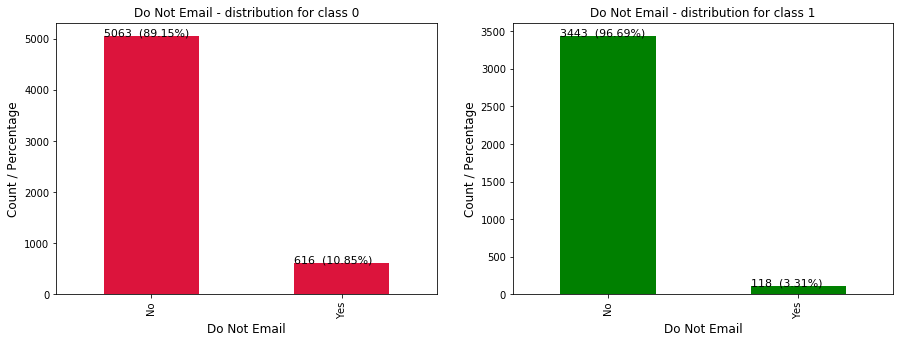

In [21]:
visualise_feature_impact(data, "Do Not Email", "categorical")
data["Do Not Email"].value_counts()

#### Note: Most of the values in this feature is "No". This may not have an impact on the target variable. 

No     9238
Yes    2   
Name: Do Not Call, dtype: int64

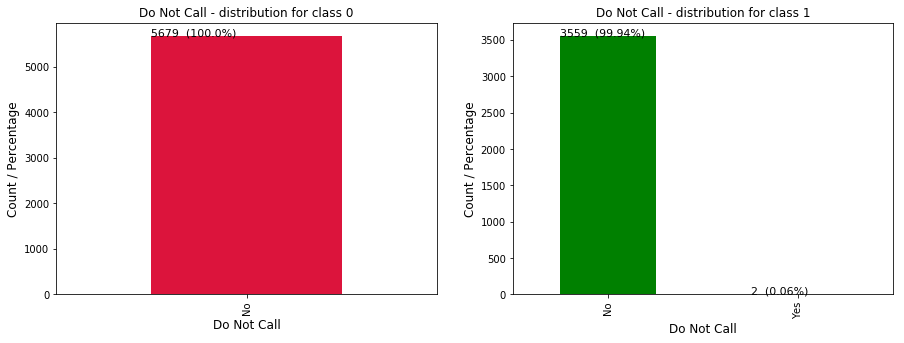

In [22]:
visualise_feature_impact(data, "Do Not Call", "categorical")
data["Do Not Call"].value_counts()

#### Note: Most of the values in this feature is "No". This will not have an impact on the target variable. 


 IQR 4.0 
 Lower limit -5.0
 Upper limit 11.0

 Minimum 0.0 
 Maximum 251.0 

There are samples which violate only upper limit
Number of outliers  267
Outliers have been removed


Original number of samples : (9240,)
Number of samples after outliers are removed : (8973,)


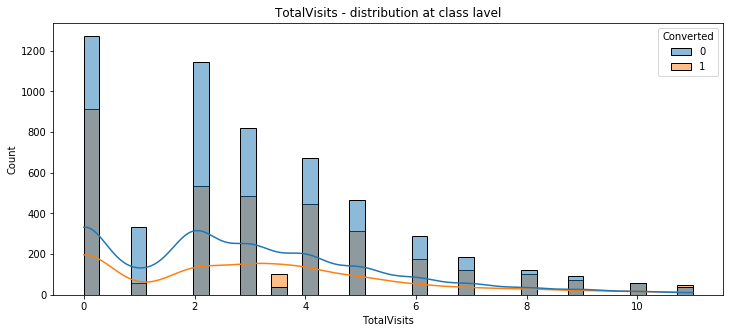

In [23]:
visualise_feature_impact(data, "TotalVisits", "numerical")

#### Note: As the number of total visits increase, the chance of conversion increases. 


 IQR 924.0 
 Lower limit -1374.0
 Upper limit 2322.0

 Minimum 0 
 Maximum 2272 

No outliers in this data


Original number of samples : (9240,)
Number of samples after outliers are removed : (9240,)


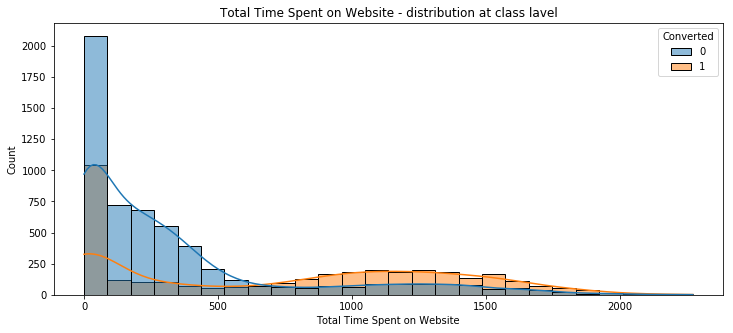

In [24]:
visualise_feature_impact(data, "Total Time Spent on Website", "numerical")

#### Note: As the time spent on the website increases, the chnace of conversion to a paying customer increases. 


 IQR 2.0 
 Lower limit -2.0
 Upper limit 6.0

 Minimum 0.0 
 Maximum 55.0 

There are samples which violate only upper limit
Number of outliers  360
Outliers have been removed


Original number of samples : (9240,)
Number of samples after outliers are removed : (8880,)


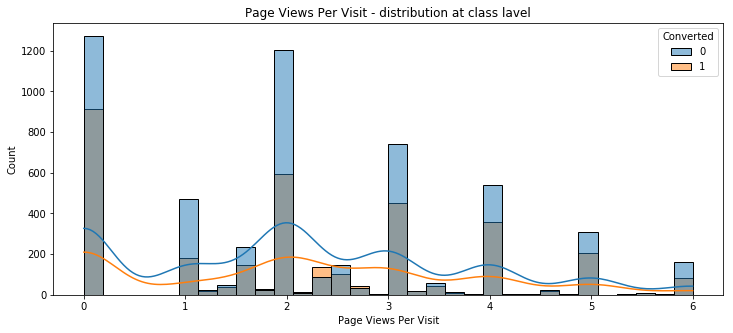

In [25]:
visualise_feature_impact(data, "Page Views Per Visit", "numerical")

#### Note: As the number of page views increases, the possibility of conversion is higher. 

India                   6492
United States           69  
United Arab Emirates    53  
Singapore               24  
Saudi Arabia            21  
United Kingdom          15  
Australia               13  
Qatar                   10  
Bahrain                 7   
Hong Kong               7   
Oman                    6   
France                  6   
unknown                 5   
Germany                 4   
Canada                  4   
Nigeria                 4   
Kuwait                  4   
South Africa            4   
Sweden                  3   
Bangladesh              2   
Italy                   2   
Ghana                   2   
Philippines             2   
China                   2   
Belgium                 2   
Asia/Pacific Region     2   
Uganda                  2   
Netherlands             2   
Indonesia               1   
Russia                  1   
Liberia                 1   
Sri Lanka               1   
Vietnam                 1   
Switzerland             1   
Denmark       

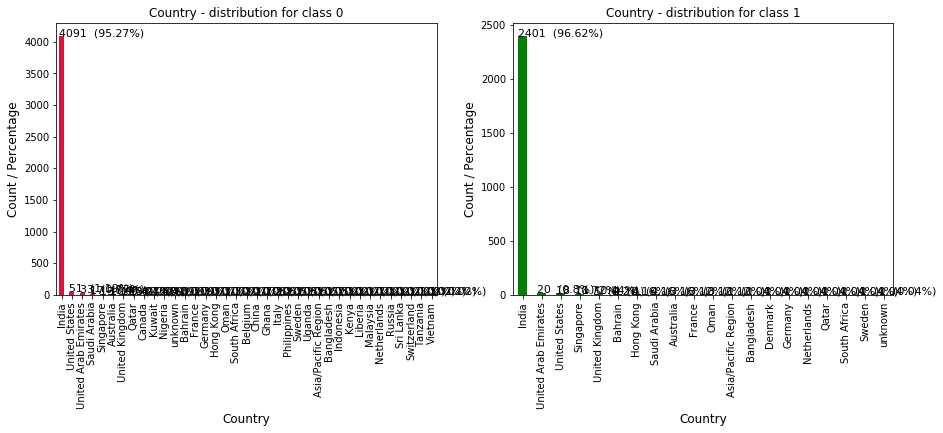

In [26]:
visualise_feature_impact(data, "Country", "categorical")
data["Country"].value_counts()

#### Note: Most of the values in this feature is "Inda". This will not have an impact on the target variable. 

Select                               1942
Finance Management                   976 
Human Resource Management            848 
Marketing Management                 838 
Operations Management                503 
Business Administration              403 
IT Projects Management               366 
Supply Chain Management              349 
Banking, Investment And Insurance    338 
Media and Advertising                203 
Travel and Tourism                   203 
International Business               178 
Healthcare Management                159 
Hospitality Management               114 
E-COMMERCE                           112 
Retail Management                    100 
Rural and Agribusiness               73  
E-Business                           57  
Services Excellence                  40  
Name: Specialization, dtype: int64

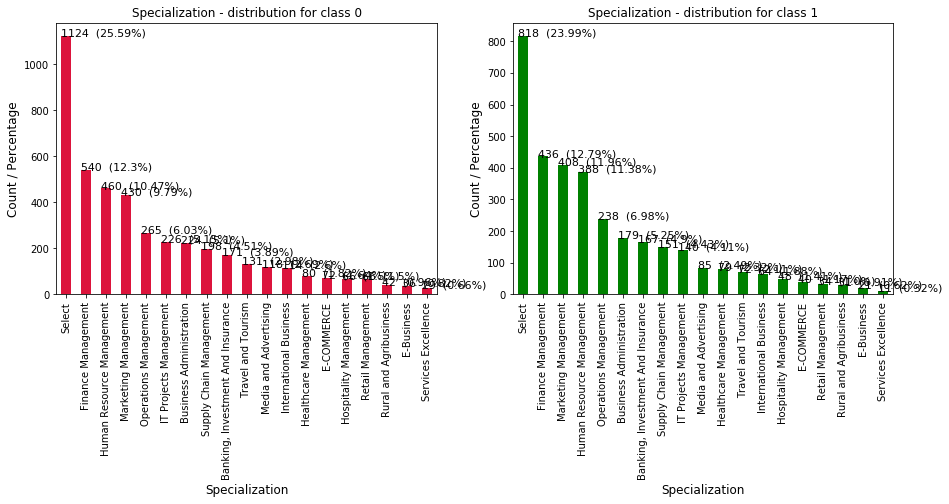

In [27]:
visualise_feature_impact(data, "Specialization", "categorical")
data["Specialization"].value_counts()

#### Note: <br> 1. Many featuers fall under "Select", i.e. value not specified by user. <br> 2. This may have an impact on the target variable.

Select                   5043
Online Search            808 
Word Of Mouth            348 
Student of SomeSchool    310 
Other                    186 
Multiple Sources         152 
Advertisements           70  
Social Media             67  
Email                    26  
SMS                      23  
Name: How did you hear about X Education, dtype: int64

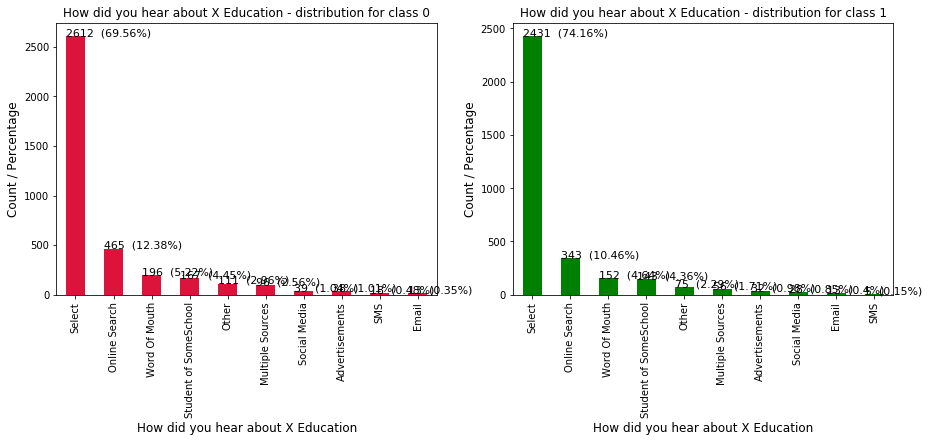

In [28]:
visualise_feature_impact(data, "How did you hear about X Education", "categorical")
data["How did you hear about X Education"].value_counts()

#### Note: <br> 1. Many featuers fall under "Select", i.e. value not specified by user. <br> 2. This may have an impact on the target variable.

Unemployed              5600
Working Professional    706 
Student                 210 
Other                   16  
Housewife               10  
Businessman             8   
Name: What is your current occupation, dtype: int64

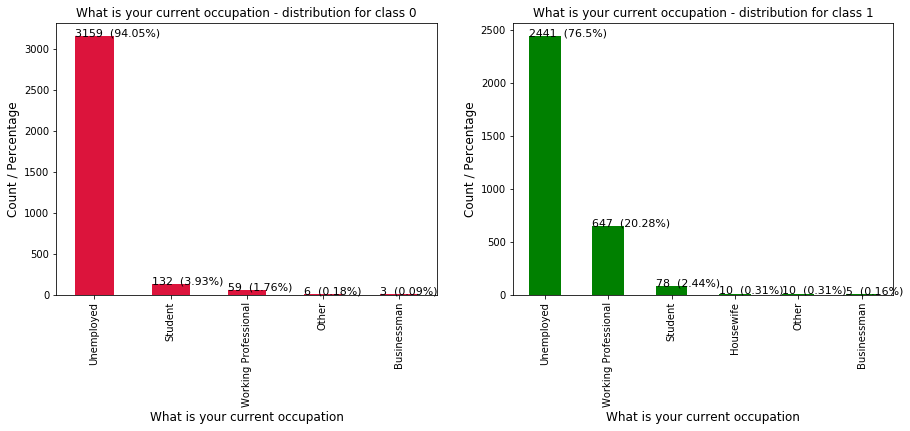

In [29]:
visualise_feature_impact(data, "What is your current occupation", "categorical")
data["What is your current occupation"].value_counts()

#### Note: A working professional is most likely to get converted to a paying customer. This feature will impact the output. 

Better Career Prospects      6528
Flexibility & Convenience    2   
Other                        1   
Name: What matters most to you in choosing a course, dtype: int64

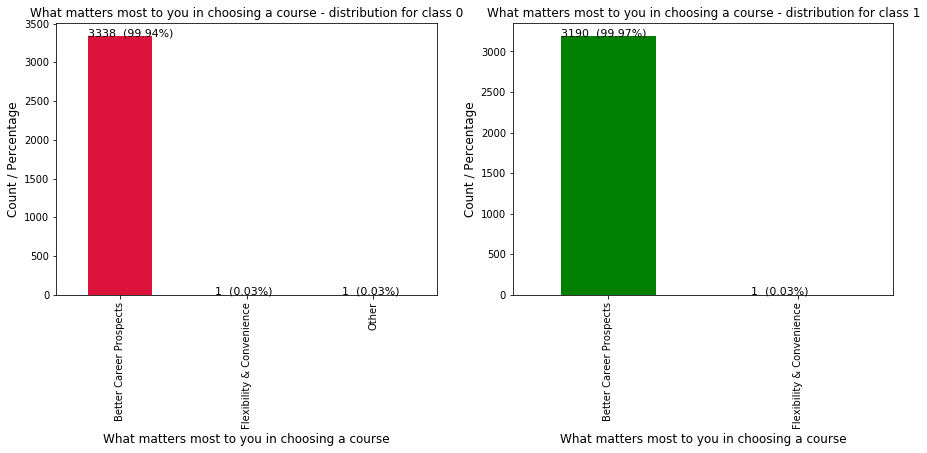

In [30]:
visualise_feature_impact(data, "What matters most to you in choosing a course", "categorical")
data["What matters most to you in choosing a course"].value_counts()

#### Note: 99% of the values are "Better career prospects". This feature will not be useful for learning. 

No     9226
Yes    14  
Name: Search, dtype: int64

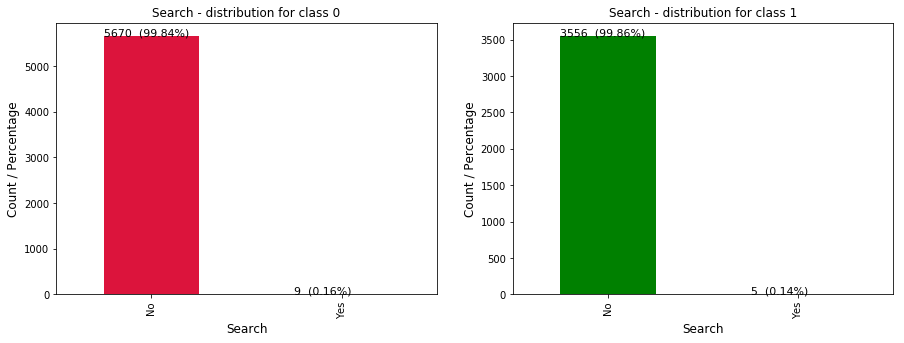

In [31]:
visualise_feature_impact(data, "Search", "categorical")
data["Search"].value_counts()

#### Note: Variety of information in this column is very less. This will not impact the target variable. 

No    9240
Name: Magazine, dtype: int64

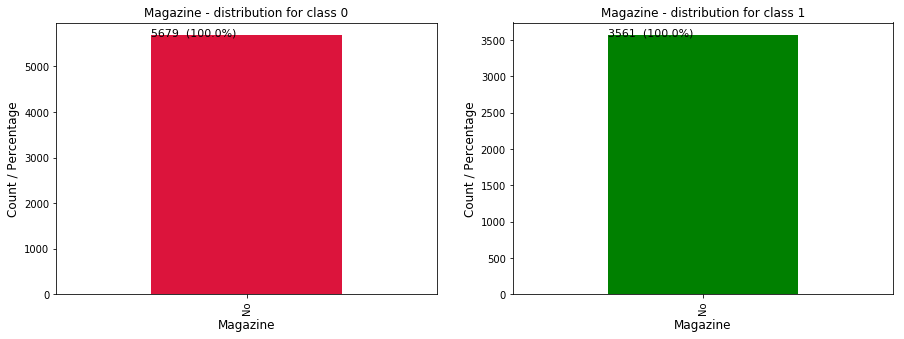

In [32]:
visualise_feature_impact(data, "Magazine", "categorical")
data["Magazine"].value_counts()

#### This feature can be ignored since there is only one type of value. 

No     9238
Yes    2   
Name: Newspaper Article, dtype: int64

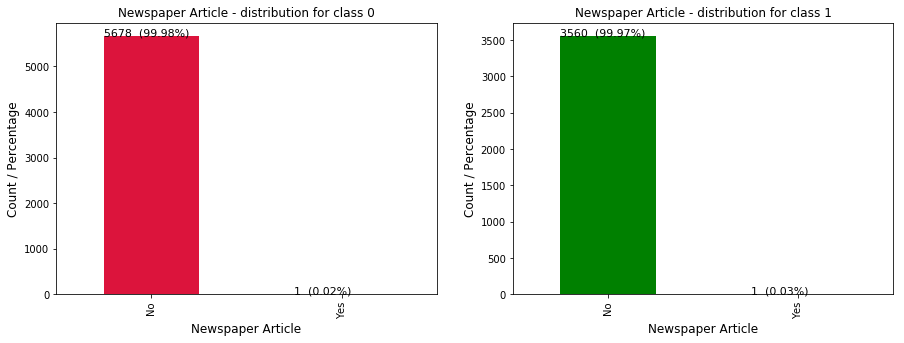

In [33]:
visualise_feature_impact(data, "Newspaper Article", "categorical")
data["Newspaper Article"].value_counts()

#### Note: This feature will not impact the output variable since 99% of the values is same.

No     9239
Yes    1   
Name: X Education Forums, dtype: int64

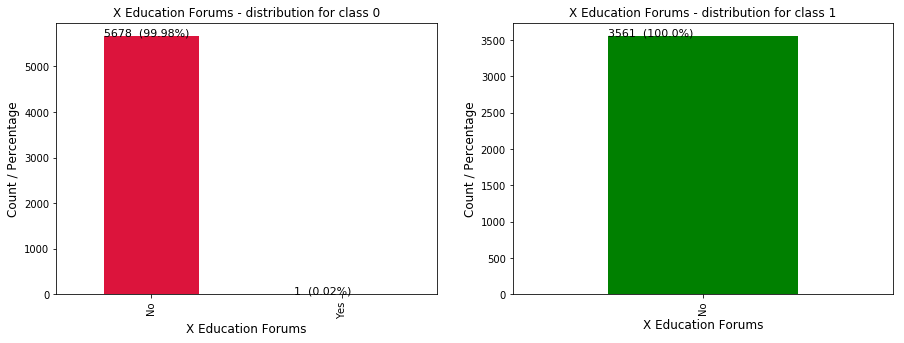

In [34]:
visualise_feature_impact(data, "X Education Forums", "categorical")
data["X Education Forums"].value_counts()

#### Note: This feature will not impact the output variable since more than 99% of the values is same.

No     9239
Yes    1   
Name: Newspaper, dtype: int64

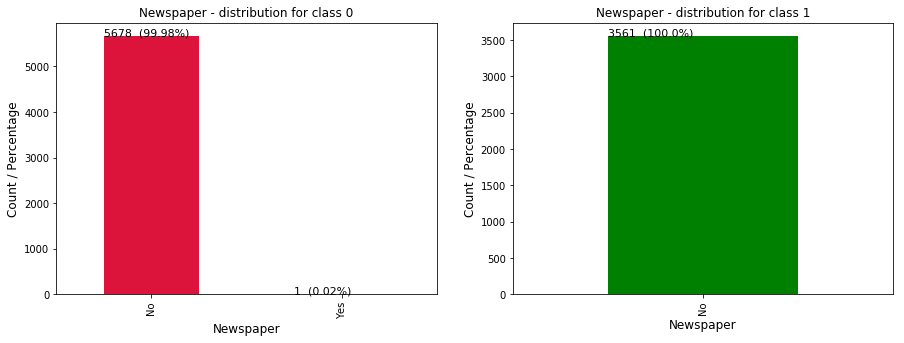

In [35]:
visualise_feature_impact(data, "Newspaper", "categorical")
data["Newspaper"].value_counts()

#### Note: This feature will not impact the output variable since more than 99% of the values is same.

No     9236
Yes    4   
Name: Digital Advertisement, dtype: int64

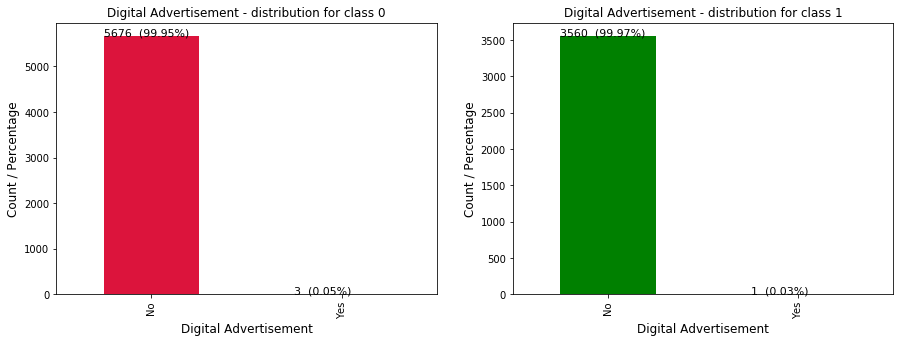

In [36]:
visualise_feature_impact(data, "Digital Advertisement", "categorical")
data["Digital Advertisement"].value_counts()

#### Note: This feature will not impact the output variable since 99% of the values is same.

No     9233
Yes    7   
Name: Through Recommendations, dtype: int64

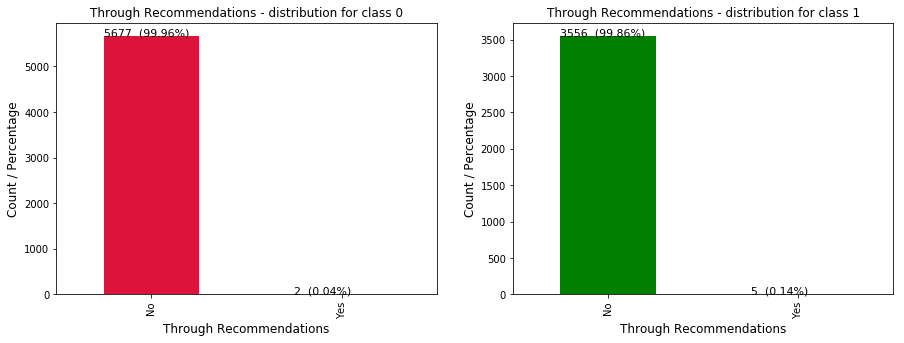

In [37]:
visualise_feature_impact(data, "Through Recommendations", "categorical")
data["Through Recommendations"].value_counts()

#### Note: This feature will not impact the output variable since 99% of the values is same.

No    9240
Name: Receive More Updates About Our Courses, dtype: int64

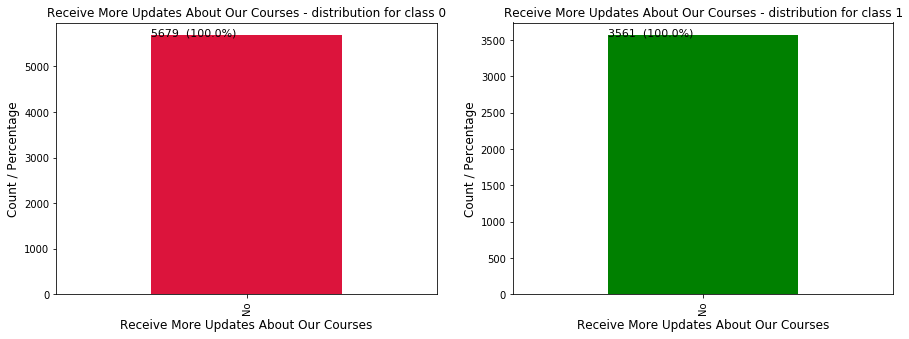

In [38]:
visualise_feature_impact(data, "Receive More Updates About Our Courses", "categorical")
data["Receive More Updates About Our Courses"].value_counts()

#### Note: This feature will not impact the output variable since all the values is same.

Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                          513 
Already a student                                    465 
Closed by Horizzon                                   358 
switched off                                         240 
Busy                                                 186 
Lost to EINS                                         175 
Not doing further education                          145 
Interested  in full time MBA                         117 
Graduation in progress                               111 
invalid number                                       83  
Diploma holder (Not Eligible)                        63  
wrong number given                                   47  
opp hangup                                           33  
number not provided                                  27  
in touch with EINS                                   12  
Lost to Others

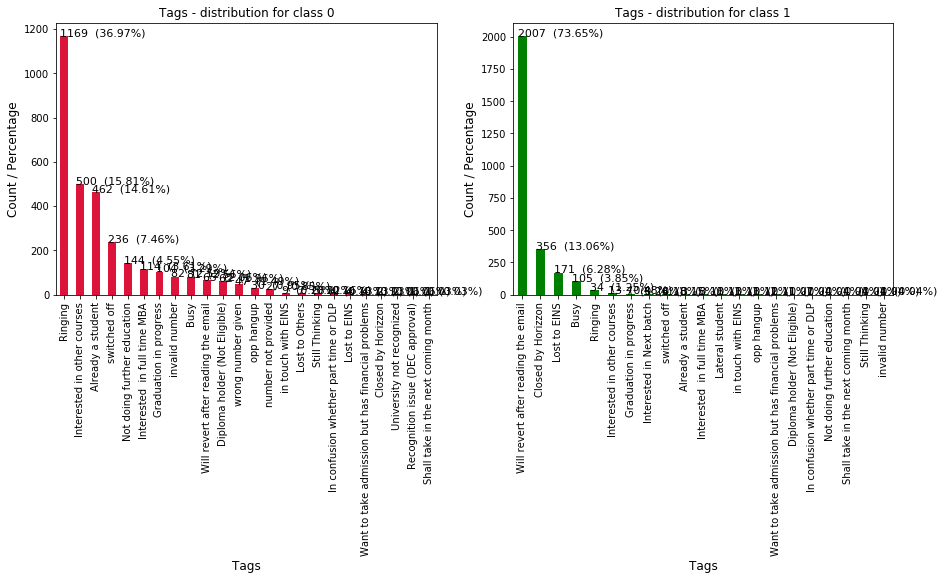

In [39]:
visualise_feature_impact(data, "Tags", "categorical")
data["Tags"].value_counts()

#### Note: <br> 1. This feature has imapct on target variable based on it's values. <br> 2. Number of samples for certain features are less, which can be combined into a separate category. 

No    9240
Name: Update me on Supply Chain Content, dtype: int64

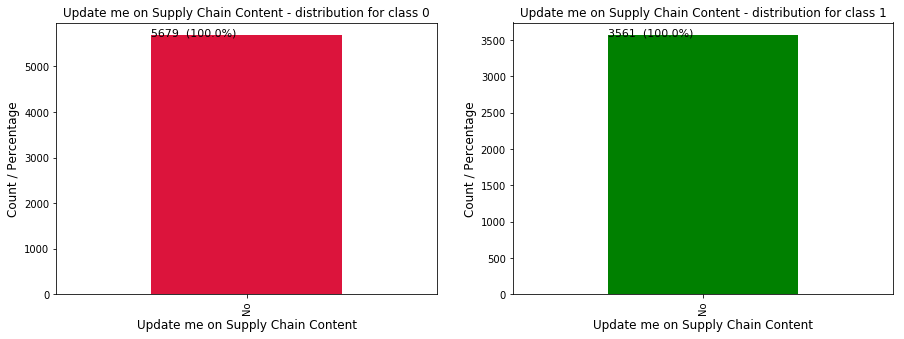

In [40]:
visualise_feature_impact(data, "Update me on Supply Chain Content", "categorical")
data["Update me on Supply Chain Content"].value_counts()

#### Note: This feature will not impact the output variable since all the values is same.

No    9240
Name: Get updates on DM Content, dtype: int64

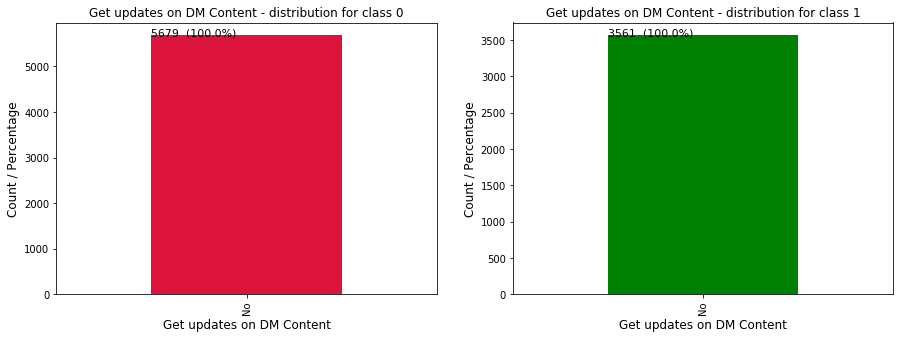

In [41]:
visualise_feature_impact(data, "Get updates on DM Content", "categorical")
data["Get updates on DM Content"].value_counts()

#### Note: This feature will not impact the output variable since all the values is same.

Select                         4146
Potential Lead                 1613
Other Leads                    487 
Student of SomeSchool          241 
Lateral Student                24  
Dual Specialization Student    20  
Name: Lead Profile, dtype: int64

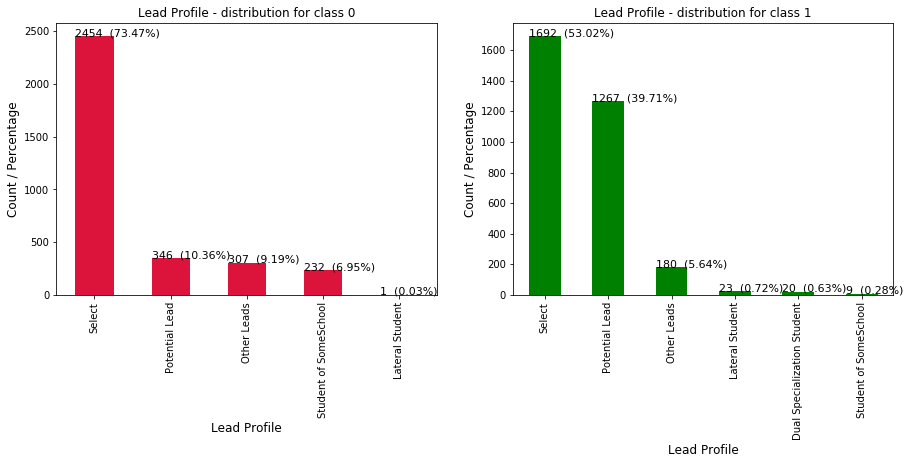

In [42]:
visualise_feature_impact(data, "Lead Profile", "categorical")
data["Lead Profile"].value_counts()

#### Note: Several values are unkown and placed in "Select". This may have an impact on the target variable. 

Mumbai                         3222
Select                         2249
Thane & Outskirts              752 
Other Cities                   686 
Other Cities of Maharashtra    457 
Other Metro Cities             380 
Tier II Cities                 74  
Name: City, dtype: int64

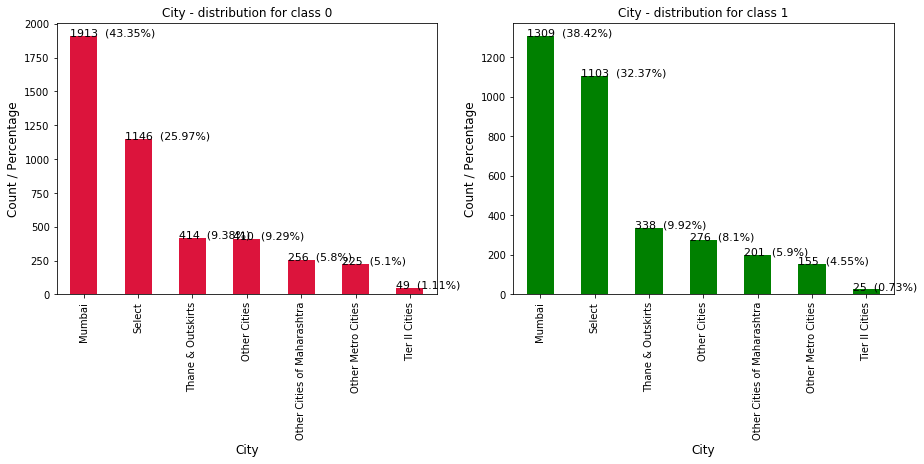

In [43]:
visualise_feature_impact(data, "City", "categorical")
data["City"].value_counts()

#### Note: This may have an impact on the output.

02.Medium    3839
01.High      821 
03.Low       362 
Name: Asymmetrique Activity Index, dtype: int64

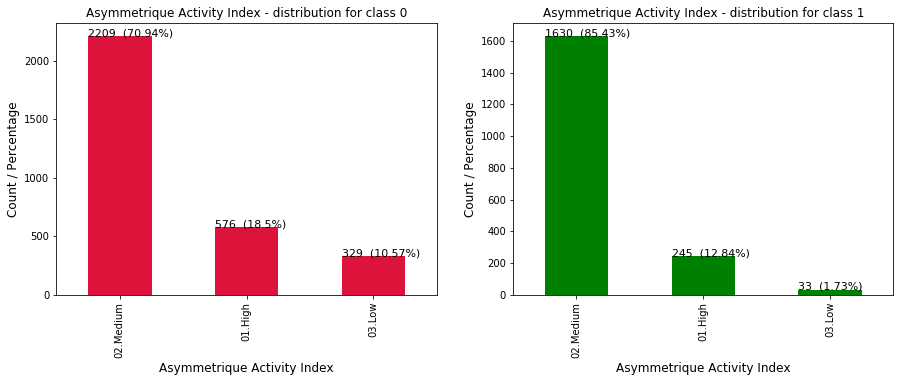

In [44]:
visualise_feature_impact(data, "Asymmetrique Activity Index", "categorical")
data["Asymmetrique Activity Index"].value_counts()

#### Note: This may have an impact on the target variable. 

02.Medium    2788
01.High      2203
03.Low       31  
Name: Asymmetrique Profile Index, dtype: int64

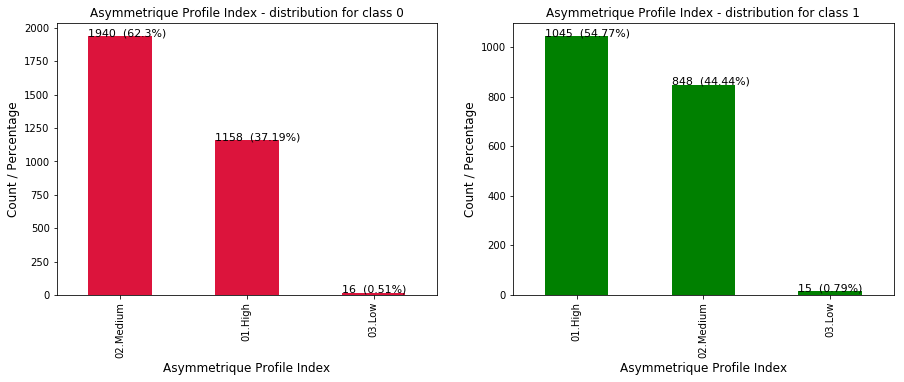

In [45]:
visualise_feature_impact(data, "Asymmetrique Profile Index", "categorical")
data["Asymmetrique Profile Index"].value_counts()

#### Note: A high profile index is likely to convert to a paying customer. 

No    9240
Name: I agree to pay the amount through cheque, dtype: int64

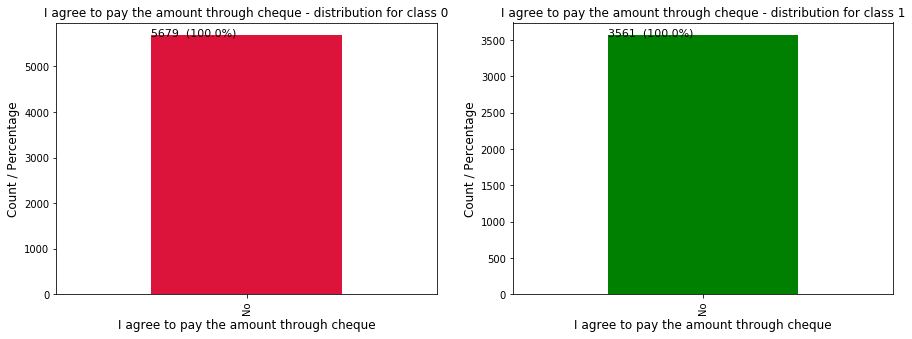

In [46]:
visualise_feature_impact(data, "I agree to pay the amount through cheque", "categorical")
data["I agree to pay the amount through cheque"].value_counts()

#### Note: This feature will not impact the output variable since all the values is same.

No     6352
Yes    2888
Name: A free copy of Mastering The Interview, dtype: int64

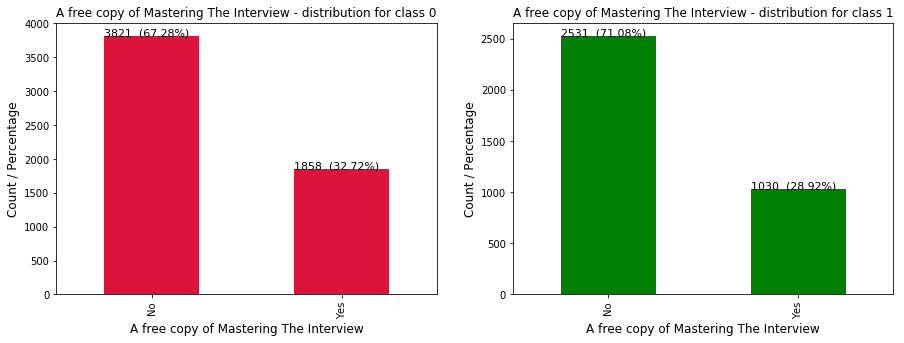

In [47]:
visualise_feature_impact(data, "A free copy of Mastering The Interview", "categorical")
data["A free copy of Mastering The Interview"].value_counts()

#### Note: This may have an impact on the target variable. 

Modified                        3407
Email Opened                    2827
SMS Sent                        2172
Page Visited on Website         318 
Olark Chat Conversation         183 
Email Link Clicked              173 
Email Bounced                   60  
Unsubscribed                    47  
Unreachable                     32  
Had a Phone Conversation        14  
Email Marked Spam               2   
View in browser link Clicked    1   
Form Submitted on Website       1   
Email Received                  1   
Resubscribed to emails          1   
Approached upfront              1   
Name: Last Notable Activity, dtype: int64

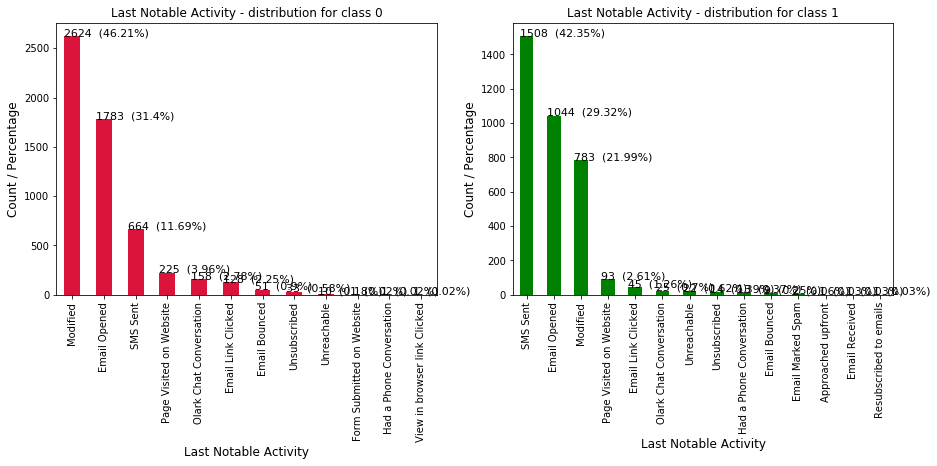

In [48]:
visualise_feature_impact(data, "Last Notable Activity", "categorical")
data["Last Notable Activity"].value_counts()

#### Note: This feature has an imapct on the target variable. Certain categories have fewer features which can be combined to a separate group like "Others". 

### Dropping irrelevant features

In [49]:
col_list = ["Do Not Call",  "Country", "What matters most to you in choosing a course", "Search", "Magazine", "Newspaper Article", "X Education Forums", "Newspaper", "Digital Advertisement", "Through Recommendations", "Receive More Updates About Our Courses", "Update me on Supply Chain Content", "Get updates on DM Content", "I agree to pay the amount through cheque"]
drop_cols(data, col_list)
print("Shape of dataset :",data.shape)
data.sample(3)

Shape of dataset : (9240, 17)


,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Specialization,How did you hear about X Education,What is your current occupation,Tags,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,A free copy of Mastering The Interview,Last Notable Activity
173,API,Google,No,0,7.0,615,7.0,"Banking, Investment And Insurance",Online Search,NaN,Interested in other courses,NaN,Thane & Outskirts,02.Medium,02.Medium,No,Modified
7272,API,Google,No,0,2.0,772,1.0,Select,Select,Unemployed,switched off,Select,Select,NaN,NaN,No,SMS Sent
1034,API,Google,No,0,2.0,14,2.0,Select,Select,Unemployed,Busy,Select,Select,02.Medium,02.Medium,No,Modified


#### Note: <br> 1. Specialization, How did you hear about X Education, City NULLs can be replaced by "Select", depicting the same information that value is not known, or these columns may be dropped. <br> 2. What is your current occupation, Tags NULLs can be addressed by categorising as a separate group. <br> 3. Lead Profile feature has 4k+ "Select" values, i.e. unknown and further ~3k NULLs. This feature can be ignored. <br> 4. Activity/Profile index NULLs can be addressed by categorising them as "Unknown".

In [50]:
col_list = ["Lead Profile"]
drop_cols(data, col_list)
print("Shape of dataset :",data.shape)

Shape of dataset : (9240, 16)


In [51]:
handle_missing_values(data, "Specialization", "mode")
handle_missing_values(data, "How did you hear about X Education", "mode")
handle_missing_values(data, "City", "Select")
handle_missing_values(data, "What is your current occupation", "Unknown_Occupation")
handle_missing_values(data, "Tags", "Unknown_Tag")
handle_missing_values(data, "Asymmetrique Activity Index", "Unknown_Activity")
handle_missing_values(data, "Asymmetrique Profile Index", "Unknown_Profile")

In [52]:
data.sample(5)

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Specialization,How did you hear about X Education,What is your current occupation,Tags,City,Asymmetrique Activity Index,Asymmetrique Profile Index,A free copy of Mastering The Interview,Last Notable Activity
240,API,Organic Search,No,1,3.0,195,3.0,Operations Management,Select,Unemployed,Will revert after reading the email,Select,02.Medium,02.Medium,No,Modified
1961,API,Olark Chat,No,1,3.0,1228,1.5,Supply Chain Management,Select,Unemployed,Busy,Mumbai,02.Medium,01.High,Yes,Modified
3235,Landing Page Submission,Direct Traffic,No,0,4.0,121,4.0,Finance Management,Select,Unknown_Occupation,Unknown_Tag,Mumbai,Unknown_Activity,Unknown_Profile,Yes,SMS Sent
2632,Lead Add Form,Reference,No,1,0.0,0,0.0,Select,Select,Unemployed,Will revert after reading the email,Select,Unknown_Activity,Unknown_Profile,No,SMS Sent
5981,Landing Page Submission,Direct Traffic,No,0,5.0,27,5.0,Marketing Management,Select,Unknown_Occupation,Unknown_Tag,Thane & Outskirts,Unknown_Activity,Unknown_Profile,Yes,SMS Sent


### Cleaning features

In [53]:
data = data[data["Lead Origin"] != "Quick Add Form"]

data["Lead Origin"].value_counts()

Landing Page Submission    4886
API                        3580
Lead Add Form              718 
Lead Import                55  
Name: Lead Origin, dtype: int64

In [54]:
data["Lead Source"] = data["Lead Source"].str.lower()
val_list = ["bing","click2call", "social media", "live chat", "press_release", "pay per click ads", "welearnblog_home", "blog", "youtubechannel", "welearn", "testone", "nc_edm"]
data["Lead Source"] = data["Lead Source"].apply(lambda x: 'other_source' if x in val_list else x) 

#data["Lead Source"].value_counts()

In [55]:
val_list = ["in touch with EINS", "Lost to Others", "Want to take admission but has financial problems", "Still Thinking", "Interested in Next batch", "In confusion whether part time or DLP", "Lateral student", "Shall take in the next coming month", "University not recognized", "Recognition issue (DEC approval)"]
data["Tags"] = data["Tags"].apply(lambda x: 'other_tags' if x in val_list else x) 

#data["Tags"].value_counts()

In [56]:
val_list = ["Had a Phone Conversation", "Email Marked Spam", "Resubscribed to emails", "View in browser link Clicked","Email Received", "Form Submitted on Website", "Approached upfront"]
data["Last Notable Activity"] = data["Last Notable Activity"].apply(lambda x: 'other_last_activity' if x in val_list else x) 

#data["Last Notable Activity"].value_counts()

In [57]:
data["Asymmetrique Activity Index"] = data["Asymmetrique Activity Index"].str.replace(".","_" )
data["Asymmetrique Profile Index"] = data["Asymmetrique Profile Index"].str.replace(".","_" )

In [58]:
data["Asymmetrique Activity Index"].value_counts()

Unknown_Activity    4218
02_Medium           3838
01_High             821 
03_Low              362 
Name: Asymmetrique Activity Index, dtype: int64

### Handling categorical features

In [59]:
data_dummy = data.copy()
data_dummy = categorical_encode(data_dummy, "Lead Origin", "o_encode")
data_dummy = categorical_encode(data_dummy, "Lead Source", "o_encode")
data_dummy = categorical_encode(data_dummy, "Specialization", "o_encode")
data_dummy = categorical_encode(data_dummy, "How did you hear about X Education", "o_encode")
data_dummy = categorical_encode(data_dummy, "What is your current occupation", "o_encode")
data_dummy = categorical_encode(data_dummy, "Tags", "o_encode")
data_dummy = categorical_encode(data_dummy, "City", "o_encode")
data_dummy = categorical_encode(data_dummy, "Last Notable Activity", "o_encode")

#data = categorical_encode(data, "Do Not Email", "l_encode")
#data = categorical_encode(data, "A free copy of Mastering The Interview", "l_encode")
data_dummy["Do Not Email"] = data_dummy["Do Not Email"].replace(['No','Yes'],[0,1])
data_dummy["A free copy of Mastering The Interview"] = data_dummy["A free copy of Mastering The Interview"].replace(['No','Yes'],[0,1])
data_dummy["Asymmetrique Activity Index"] = data_dummy["Asymmetrique Activity Index"].replace(['Unknown_Activity','03_Low', '02_Medium', '01_High'],[0,1,2,3])
data_dummy["Asymmetrique Profile Index"] = data_dummy["Asymmetrique Profile Index"].replace(['Unknown_Profile','03_Low', '02_Medium', '01_High'],[0,1,2,3])

print("Shape of dataset :",data_dummy.shape)
data_dummy.sample(5)

Shape of dataset : (9239, 84)


,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Index,Asymmetrique Profile Index,A free copy of Mastering The Interview,Landing Page Submission,Lead Add Form,Lead Import,facebook,google,olark chat,organic search,other_source,reference,referral sites,welingak website,Business Administration,E-Business,E-COMMERCE,Finance Management,Healthcare Management,Hospitality Management,Human Resource Management,IT Projects Management,International Business,Marketing Management,Media and Advertising,Operations Management,Retail Management,Rural and Agribusiness,Select,Services Excellence,Supply Chain Management,Travel and Tourism,Email,Multiple Sources,Online Search,Other,SMS,Select,Social Media,Student of SomeSchool,Word Of Mouth,Housewife,Other,Student,Unemployed,Unknown_Occupation,Working Professional,Busy,Closed by Horizzon,Diploma holder (Not Eligible),Graduation in progress,Interested in full time MBA,Interested in other courses,Lost to EINS,Not doing further education,Ringing,Unknown_Tag,Will revert after reading the email,invalid number,number not provided,opp hangup,other_tags,switched off,wrong number given,Other Cities,Other Cities of Maharashtra,Other Metro Cities,Select,Thane & Outskirts,Tier II Cities,Email Link Clicked,Email Opened,Modified,Olark Chat Conversation,Page Visited on Website,SMS Sent,Unreachable,Unsubscribed,other_last_activity
5239,0,0,0.0,0,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
7329,0,1,5.0,282,1.67,2,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7033,1,1,0.0,0,0.00,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
8733,1,0,1.0,167,1.00,2,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2685,0,1,4.0,1847,2.00,2,3,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [60]:
data.sample(5)

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Specialization,How did you hear about X Education,What is your current occupation,Tags,City,Asymmetrique Activity Index,Asymmetrique Profile Index,A free copy of Mastering The Interview,Last Notable Activity
8670,API,olark chat,No,0,0.0,0,0.0,Select,Select,Unknown_Occupation,Unknown_Tag,Select,02_Medium,02_Medium,No,Email Opened
3342,Landing Page Submission,google,Yes,0,5.0,1021,5.0,Human Resource Management,Word Of Mouth,Unemployed,Ringing,Mumbai,Unknown_Activity,Unknown_Profile,No,SMS Sent
5668,Landing Page Submission,direct traffic,No,0,6.0,173,3.0,Human Resource Management,Online Search,Unemployed,Unknown_Tag,Thane & Outskirts,Unknown_Activity,Unknown_Profile,Yes,Page Visited on Website
1573,Lead Add Form,reference,No,1,0.0,0,0.0,Marketing Management,Select,Unemployed,Will revert after reading the email,Select,02_Medium,01_High,No,Modified
8562,API,organic search,No,1,9.0,1573,4.5,Operations Management,Select,Unemployed,Unknown_Tag,Other Metro Cities,02_Medium,02_Medium,Yes,Modified


### Feature selection using Mutual Information 

In [61]:
features = data_dummy.drop(["Converted"], axis = 1)
target = data_dummy["Converted"]

MI = mutual_info_classif(np.array(features), np.array(target), discrete_features=True)
MI_data = pd.concat([pd.DataFrame(features.columns),pd.DataFrame(MI)], axis = 1)
MI_data.columns = ["Features", "Mutual Information"]
MI_data.sort_values(by = "Mutual Information", ascending = False)

,Features,Mutual Information
2,Total Time Spent on Website,2.356124e-01
61,Will revert after reading the email,2.298675e-01
79,SMS Sent,6.104224e-02
49,Unknown_Occupation,5.890968e-02
8,Lead Add Form,5.473129e-02
59,Ringing,5.350247e-02
50,Working Professional,5.175572e-02
15,reference,3.859315e-02
52,Closed by Horizzon,3.674744e-02
76,Modified,3.108083e-02


#### Note: From MI scores, the following features will be considered for modeling: <br> 1. Total Time Spent on Website <br> 2. Tags <br> 3. Last Notable Activity <br> 4. What is your current occupation <br> 5. Lead Origin <br> 6. Page Views per visit <br> 7. Total visits <br> 8. Lead Source <br> 9. Asymmetrique Activity Index <br> 10. Do Not Email <br> 11. Asymmetrique Profile Index 

In [62]:
data_f = data[["Lead Origin", "Lead Source", "What is your current occupation", "Tags", "Last Notable Activity", "Do Not Email", "Asymmetrique Activity Index", "Asymmetrique Profile Index", "Total Time Spent on Website", "Page Views Per Visit", "TotalVisits", "Converted"]]


In [63]:
data_f = categorical_encode(data_f, "Lead Origin", "o_encode")
data_f = categorical_encode(data_f, "Lead Source", "o_encode")
data_f = categorical_encode(data_f, "What is your current occupation", "o_encode")
data_f = categorical_encode(data_f, "Tags", "o_encode")
data_f = categorical_encode(data_f, "Last Notable Activity", "o_encode")

#data = categorical_encode(data, "Do Not Email", "l_encode")
#data = categorical_encode(data, "A free copy of Mastering The Interview", "l_encode")
data_f["Do Not Email"] = data_f["Do Not Email"].replace(['No','Yes'],[0,1])
data_f["Asymmetrique Activity Index"] = data_f["Asymmetrique Activity Index"].replace(['Unknown_Activity','03_Low', '02_Medium', '01_High'],[0,1,2,3])
data_f["Asymmetrique Profile Index"] = data_f["Asymmetrique Profile Index"].replace(['Unknown_Profile','03_Low', '02_Medium', '01_High'],[0,1,2,3])

print("Shape of dataset :",data_f.shape)
data_f.sample(5)

Shape of dataset : (9239, 50)


,Do Not Email,Asymmetrique Activity Index,Asymmetrique Profile Index,Total Time Spent on Website,Page Views Per Visit,TotalVisits,Converted,Landing Page Submission,Lead Add Form,Lead Import,facebook,google,olark chat,organic search,other_source,reference,referral sites,welingak website,Housewife,Other,Student,Unemployed,Unknown_Occupation,Working Professional,Busy,Closed by Horizzon,Diploma holder (Not Eligible),Graduation in progress,Interested in full time MBA,Interested in other courses,Lost to EINS,Not doing further education,Ringing,Unknown_Tag,Will revert after reading the email,invalid number,number not provided,opp hangup,other_tags,switched off,wrong number given,Email Link Clicked,Email Opened,Modified,Olark Chat Conversation,Page Visited on Website,SMS Sent,Unreachable,Unsubscribed,other_last_activity
2901,0,0,0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3550,0,0,0,633,5.0,5.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4972,0,0,0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7231,0,2,2,0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7218,1,1,3,150,2.0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Train-test datasets

In [64]:
X = data_f.drop(["Converted"], axis = 1)
Y = data_f["Converted"]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=999)

train_mean = x_train.mean()
train_std = x_train.std()
x_train_scaled = (x_train - train_mean)/train_std
x_test_scaled = (x_test - train_mean)/train_std

### Modeling

In [65]:
lr = LogisticRegression()
print("Cross validation scores:\n",cross_val_score(lr, x_train_scaled, y_train, cv=10))

lr.fit(x_train_scaled, y_train)
pred_vals = lr.predict(x_test_scaled)

pred_vals_df = pd.DataFrame(pred_vals)

Cross validation scores:
 [0.93648649 0.94316644 0.9391069  0.94451962 0.94181326 0.94046008
 0.94181326 0.93504736 0.94451962 0.93504736]


### Model performance evaluation

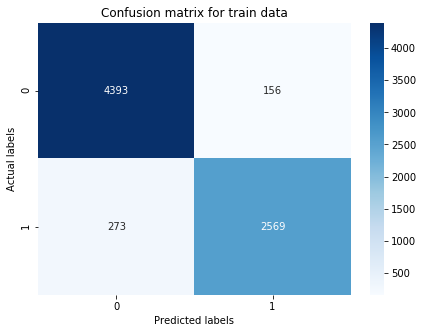

In [66]:
conf = confusion_matrix(y_train,pd.DataFrame(lr.predict(x_train_scaled)))
label = [0,1]
plt.figure(figsize=(7,5))
sns.heatmap(conf, annot=True, xticklabels=label, yticklabels=label,cmap='Blues', fmt='g')
plt.title("Confusion matrix for train data")
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.show()

In [67]:
print("Classification report for train data: \n")
print(classification_report(y_train,pd.DataFrame(lr.predict(x_train_scaled)), labels=label))

Classification report for train data: 

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      4549
           1       0.94      0.90      0.92      2842

    accuracy                           0.94      7391
   macro avg       0.94      0.93      0.94      7391
weighted avg       0.94      0.94      0.94      7391



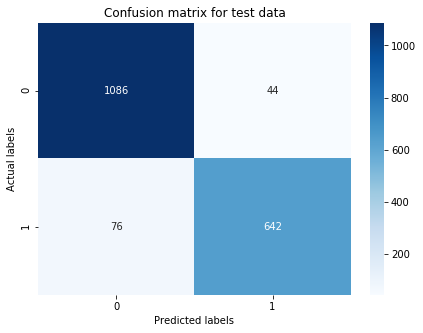

In [68]:
conf = confusion_matrix(y_test,pred_vals_df)
label = [0,1]
plt.figure(figsize=(7,5))
sns.heatmap(conf, annot=True, xticklabels=label, yticklabels=label,cmap='Blues', fmt='g')
plt.title("Confusion matrix for test data")
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.show()

In [69]:
print("Classification report for test data: \n")
print(classification_report(y_test,pred_vals_df, labels=label))

Classification report for test data: 

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1130
           1       0.94      0.89      0.91       718

    accuracy                           0.94      1848
   macro avg       0.94      0.93      0.93      1848
weighted avg       0.94      0.94      0.93      1848



In [70]:
print("Overall model accuracy for train data : ", round(metrics.accuracy_score(y_train,pd.DataFrame(lr.predict(x_train_scaled))),3))
print("Overall model accuracy for test data : ", round(metrics.accuracy_score(y_test,pred_vals_df),3))

Overall model accuracy for train data :  0.942
Overall model accuracy for test data :  0.935


AUC score train and test :  0.935 0.928


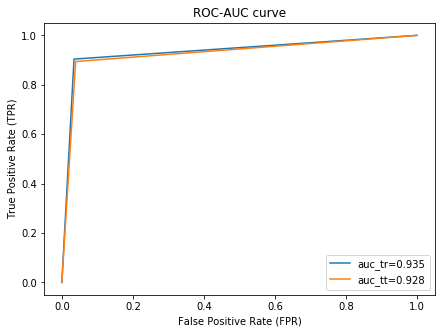

In [71]:
fpr_tr, tpr_tr, _ = metrics.roc_curve(y_train,pd.DataFrame(lr.predict(x_train_scaled)))
auc_tr = round(metrics.roc_auc_score(y_train,pd.DataFrame(lr.predict(x_train_scaled))),3)

fpr_tt, tpr_tt, _ = metrics.roc_curve(y_test, pred_vals_df)
auc_tt = round(metrics.roc_auc_score(y_test, pred_vals_df),3)

print("AUC score train and test : ",auc_tr, auc_tt)

plt.figure(figsize=(7,5))
plt.title("ROC-AUC curve")
plt.plot(fpr_tr,tpr_tr, label="auc_tr="+str(auc_tr))
plt.plot(fpr_tt,tpr_tt, label="auc_tt="+str(auc_tt))
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc=4)
plt.show()

### Note: Model performance can be improved through parameter tuning, using different algorithms etc. 